# Les _notebooks_ et `Git`

::: {.callout-important}
## A ne pas reproduire chez vous

Ce document vise à illustrer les enjeux du contrôle de version avec un _notebook_. Il ne correspond absolument pas à un modèle à reproduire, bien au contraire.
:::

In [10]:
import duckdb

df = duckdb.sql(
    f"""
        SELECT *
        FROM read_parquet('{temp_file_path}') 
        WHERE
            starts_with(TYPEQU, 'F1')
            AND longitude BETWEEN 2.327943 AND 2.399054
            AND latitude BETWEEN 48.912967 AND 48.939077
    """
).to_df()


In [11]:
import requests
from tqdm import tqdm
import tempfile

url_bpe = "https://www.insee.fr/fr/statistiques/fichier/8217525/BPE23.parquet"


def download_file_to_tempfile(url: str):
    try:
        # Send a GET request to the URL
        response = requests.get(url, stream=True)
        # Raise an exception for HTTP errors
        response.raise_for_status()
        
        # Get the total file size from the headers (if available)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kilobyte

        # Progress bar setup
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc="Downloading file")
        
        # Create a temporary file
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.parquet')
        temp_filename = temp_file.name
        
        # Write the content to the temporary file
        with temp_file as file:
            for chunk in response.iter_content(chunk_size=block_size):
                progress_bar.update(len(chunk))
                file.write(chunk)
        
        progress_bar.close()
        print(f"File downloaded successfully to temp file: {temp_filename}")
        return temp_filename  # Return the path of the temporary file
    
    except requests.exceptions.RequestException as e:
        print(f"Failed to download the file: {e}")
        return None

In [12]:
temp_file_path = download_file_to_tempfile(url_bpe)

File downloaded successfully to temp file: /tmp/tmpjvx6sx9m.parquet


In [13]:
df.head(20)

,AN,NOMRS,CNOMRS,NUMVOIE,INDREP,TYPVOIE,LIBVOIE,CADR,CODPOS,DEPCOM,...,QUALI_QVA,ZUS,QUALI_ZUS,EPCI,UU2020,BV2022,AAV2020,DENS3,DENS7,LIBCOM
0,2023,COMPLEXE SPORTIF JEAN MOULIN,TERRAIN DE BOULES COUVERT,,,AV,JEAN MOULIN,,92390,92078,...,_Z,HZ,3,200054781,00851,75056,001,1,1,VILLENEUVE-LA-GARENNE
1,2023,COMPLEXE SPORTIF JEAN MOULIN,TERRAIN DE TENNIS EXTERIEUR 3,,,AV,JEAN MOULIN,,92390,92078,...,_Z,HZ,3,200054781,00851,75056,001,1,1,VILLENEUVE-LA-GARENNE
2,2023,STADE GASTON BOUILLANT,STADE D'ATHLETISME,,,AV,PIERRE DE COUBERTIN,,92390,92078,...,_Z,HZ,3,200054781,00851,75056,001,1,1,VILLENEUVE-LA-GARENNE


<Axes: xlabel='TYPEQU'>

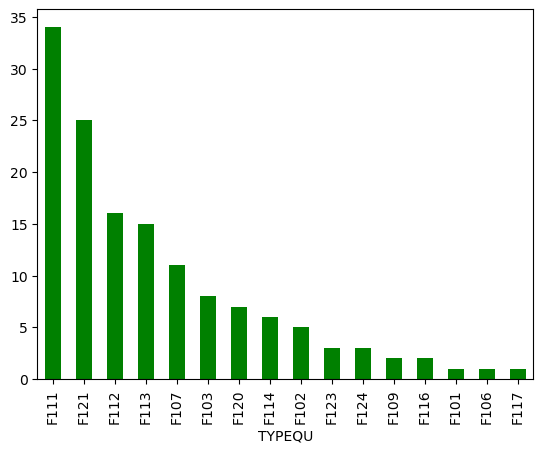

In [23]:
df["TYPEQU"].value_counts().plot(kind = "bar", color="green")

In [14]:
!pip install geopandas

In [15]:
import geopandas as gpd

In [16]:
df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE), crs="EPSG:4326"
)

In [20]:
import folium

# Create a base map centered around the average of the coordinates provided
map_center = [df['geometry'].y.mean(), df['geometry'].x.mean()]
folium_map = folium.Map(location=map_center, zoom_start=13)

# Iterate through the DataFrame and add markers
for _, row in df.iterrows():
    # Extract latitude and longitude from geometry
    lat, lon = row['geometry'].y, row['geometry'].x
    # Extract label and type for the popup and color
    name = row['NOMRS']
    typequ = row['TYPEQU']

    # Add a marker to the map
    folium.Marker(
        location=[lat, lon],
        popup=f"<b>{name}</b>\n \n \n<b>Catégorie</b>: {typequ}",  # Use NOMRS, Libelle_TYPEQU, and TYPEQU as the popup information
        icon=folium.Icon(icon="info-sign"),
    ).add_to(folium_map)

folium_map